In [ ]:
# Resources:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# https://github.com/soumith/ganhacks
# https://arxiv.org/pdf/1610.09585 : Conditional Image Synthesis with auxiliary classifier GANs

In [1]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import os.path
from torch.utils.data import DataLoader
import random
import wandb
import gc

In [2]:
# import pytorch datasets
from torchvision import datasets as Datasets
from torchvision import transforms

cifar10_train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((64, 64), antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


cifar10_test_transforms = transforms.Compose([
    transforms.Resize((64, 64), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#  loading training data
training_set = Datasets.CIFAR10(root='./', download=True, train=True, transform=cifar10_train_transforms)

#  loading validation data
validation_set = Datasets.CIFAR10(root='./', download=True, train=False, transform=cifar10_test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Dict for label to class
l2c = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [4]:
# Create data loaders
batch_size = 1024
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

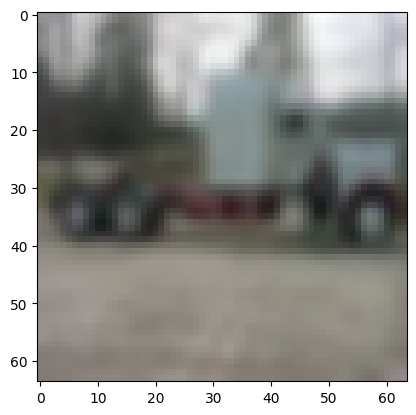

In [5]:
# Show image
img, label = next(iter(train_loader))
plt.imshow(img[0].permute(1, 2, 0)*.5+.5)

In [6]:
config = {
    'noise_dim': 100,
    'img_size': 64,
    'channels': 3,
    'batch_size': batch_size,
    'lr': 2e-4,
    'dropout': 0.3,
    'seed': 100,
    'betas': (0.5, 0.999),
    'num_classes': 10
}

In [ ]:
wandb.finish()

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("wandb"))
wandb.init(
    project='GAN_cifar10',
    entity='ritishtest1',

    config=config
    )

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std
    
    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.std
            return x + noise
        return x
    
class disc_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, batch_norm=True, leaky_relu_slope=0.2, noise_std=0.1):
        super().__init__()
        self.net = nn.Sequential(
            GaussianNoise(noise_std),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
        )

    def forward(self, x):
        return self.net(x)
    
class gen_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, batch_norm=True, activation='gelu', noise_std=0.1):
        super().__init__()
        self.net = nn.Sequential(
            GaussianNoise(noise_std),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            nn.GELU() if activation == 'gelu' else nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)
    
class Generator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.net = nn.Sequential(
            gen_block(config['noise_dim'] + config['num_classes'], config['img_size']*8, 4, 1, 0),
            gen_block(config['img_size']*8, config['img_size']*4, 4, 2, 1),
            gen_block(config['img_size']*4, config['img_size']*2, 4, 2, 1),
            gen_block(config['img_size']*2, config['img_size'], 4, 2, 1),
            nn.ConvTranspose2d(config['img_size'], config['channels'], 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.net = nn.Sequential(
            disc_block(config['channels'], config['img_size'], 4, 2, 1, bias=False),     # 64x64 -> 32x32
            disc_block(config['img_size'], config['img_size']*2, 4, 2, 1, bias=False),   # 32x32 -> 16x16
            disc_block(config['img_size']*2, config['img_size']*4, 4, 2, 1, bias=False), # 16x16 -> 8x8
            disc_block(config['img_size']*4, config['img_size']*8, 4, 2, 1, bias=False), # 8x8 -> 4x4
        )
        
        self.binary_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(config['img_size']*8*4*4, 1, bias=False),
            nn.Sigmoid()
        )
        
        self.aux_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(config['img_size']*8*4*4, 10, bias=False),
        )
        self.apply(weights_init)

    def forward(self, x):
        x = self.net(x)
        return self.binary_classifier(x), self.aux_classifier(x)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(config['seed'])
G = Generator(config).to(device)
D = Discriminator(config).to(device)

fixed_noise = torch.randn(32, config['noise_dim'], 1, 1, device=device)
fixed_labels = torch.randint(0, 10, (32,))
fixed_noise = torch.cat((fixed_noise, F.one_hot(fixed_labels, 10).float().view(32, 10, 1, 1).to(device)), dim=1)

In [12]:
def log_images(G, noise, labels):
    with torch.no_grad():
        fake = G(noise).detach().cpu().permute(0,2,3,1).numpy()*.5+.5
        wandb.log({'images': [wandb.Image(img, caption=l2c[label.item()]) for img, label in zip(fake, labels)]}, commit=False)
        print('Images logged to wandb.')

In [37]:
config['lr'] = 8e-5
BCEloss = nn.BCELoss()        # -a*torch.log(D(x)) - (1-a)*torch.log(1-D(G(z)))
CEloss = nn.CrossEntropyLoss() # -torch.log(P(y|x))
optimizer_G = optim.Adam(G.parameters(), lr=config['lr'], betas=config['betas'])
optimizer_D = optim.Adam(D.parameters(), lr=config['lr'], betas=config['betas'])

In [50]:
# Put model in training mode
G.train()
D.train()

for epoch in range(25):
    for i, (img, labels) in enumerate(train_loader):
        # One hot encoding the labels
        labels = F.one_hot(labels, 10).float().to(device)
        
        # Label smoothing
        real_label = 0.9
        fake_label = 0.1
        
        # Move data to device
        img = img.to(device)
        batch_size = img.size(0)

        # Train discriminator with real images (Since batch norm won't work well with both real and fake images, we train them separately)
        D.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        d_out_real, d_out_real_label = D(img)
        d_out_real = d_out_real.view(-1)

        # Calculate loss for images and labels
        loss_real = BCEloss(d_out_real, label)
        label_loss_real = CEloss(d_out_real_label, labels)        # Auxiliary classifier loss
        loss_real = loss_real + label_loss_real

        # Calculate gradients for real inputs
        loss_real.backward()
        D_x = d_out_real.mean().item()

        # Train discriminator with fake images
        noise = torch.randn(batch_size, config['noise_dim'], 1, 1).to(device)
        noise = torch.cat((noise, labels.view(batch_size, 10, 1, 1)), dim=1)
        fake_img = G(noise)
        label.fill_(fake_label)
        d_out_fake, d_out_fake_label = D(fake_img.detach())      # Only update the disciminator, gradients shouldn't pass through the generator
        d_out_fake = d_out_fake.view(-1)

        # Calculate loss for fake images and labels
        loss_fake = BCEloss(d_out_fake, label)
        label_loss_fake = CEloss(d_out_fake_label, labels)       # Auxiliary classifier loss
        loss_fake = loss_fake + label_loss_fake

        # Calculate gradients for fake inputs
        loss_fake.backward()
        D_G_z1 = d_out_fake.mean().item()
        d_loss = loss_real + loss_fake
        optimizer_D.step()

        # Train generator
        G.zero_grad()
        label.fill_(real_label)
        d_out_fake, d_out_fake_label = D(fake_img)              # Update the generator after discriminator update
        d_out_fake = d_out_fake.view(-1)

        # Calculate loss for generator
        gen_loss = BCEloss(d_out_fake, label)     # Just maximize log(D(G(z))
        label_loss_gen = CEloss(d_out_fake_label, labels)       # Auxiliary classifier loss
        gen_loss = gen_loss + label_loss_gen

        gen_loss.backward()
        D_G_z2 = d_out_fake.mean().item()
        optimizer_G.step()

        if i % 20 == 0:
            print(f"Epoch {epoch+1}, Step {i}, D(x): {D_x}, D(G(z)): {D_G_z1}/{D_G_z2}, Loss D: {d_loss.item()}, Loss G: {gen_loss.item()}, Label Loss Real: {label_loss_real.item()}, Label Loss Fake: {label_loss_fake.item()}, Label Loss Gen: {label_loss_gen.item()}")
            wandb.log({'D(x)': D_x, 'D(G(z))_1': D_G_z1, 'D(G(z))_2': D_G_z2, 'Loss D': d_loss.item(), 'Loss G': gen_loss.item(), 'D_LR': optimizer_D.param_groups[0]['lr'], 'G_LR': optimizer_G.param_groups[0]['lr'], 'Label Loss Real': label_loss_real.item(), 'Label Loss Fake': label_loss_fake.item(), 'Label Loss Gen': label_loss_gen.item()})
            gc.collect()
            torch.cuda.empty_cache()

    # Log images to wandb
    if epoch % 3 == 0:
        G.eval()
        log_images(G, fixed_noise, fixed_labels)
        G.train()

Epoch 1, Step 0, D(x): 0.6378196477890015, D(G(z)): 0.31329435110092163/0.3186732530593872, Loss D: 1.1530226469039917, Loss G: 1.1646205186843872, Label Loss Real: 0.10761722922325134, Label Loss Fake: 0.03816637396812439, Label Loss Gen: 0.02785535901784897
Epoch 1, Step 20, D(x): 0.6945366263389587, D(G(z)): 0.40162304043769836/0.25094908475875854, Loss D: 1.2140673398971558, Loss G: 1.3765673637390137, Label Loss Real: 0.13006219267845154, Label Loss Fake: 0.03581830859184265, Label Loss Gen: 0.024383384734392166
Epoch 1, Step 40, D(x): 0.564646303653717, D(G(z)): 0.2832219898700714/0.39236384630203247, Loss D: 1.238051176071167, Loss G: 0.9598861932754517, Label Loss Real: 0.13240453600883484, Label Loss Fake: 0.029865112155675888, Label Loss Gen: 0.020413987338542938
Images logged to wandb.
Epoch 2, Step 0, D(x): 0.7103949189186096, D(G(z)): 0.46688252687454224/0.21709486842155457, Loss D: 1.2885894775390625, Loss G: 1.5134462118148804, Label Loss Real: 0.12884467840194702, Label

KeyboardInterrupt: 

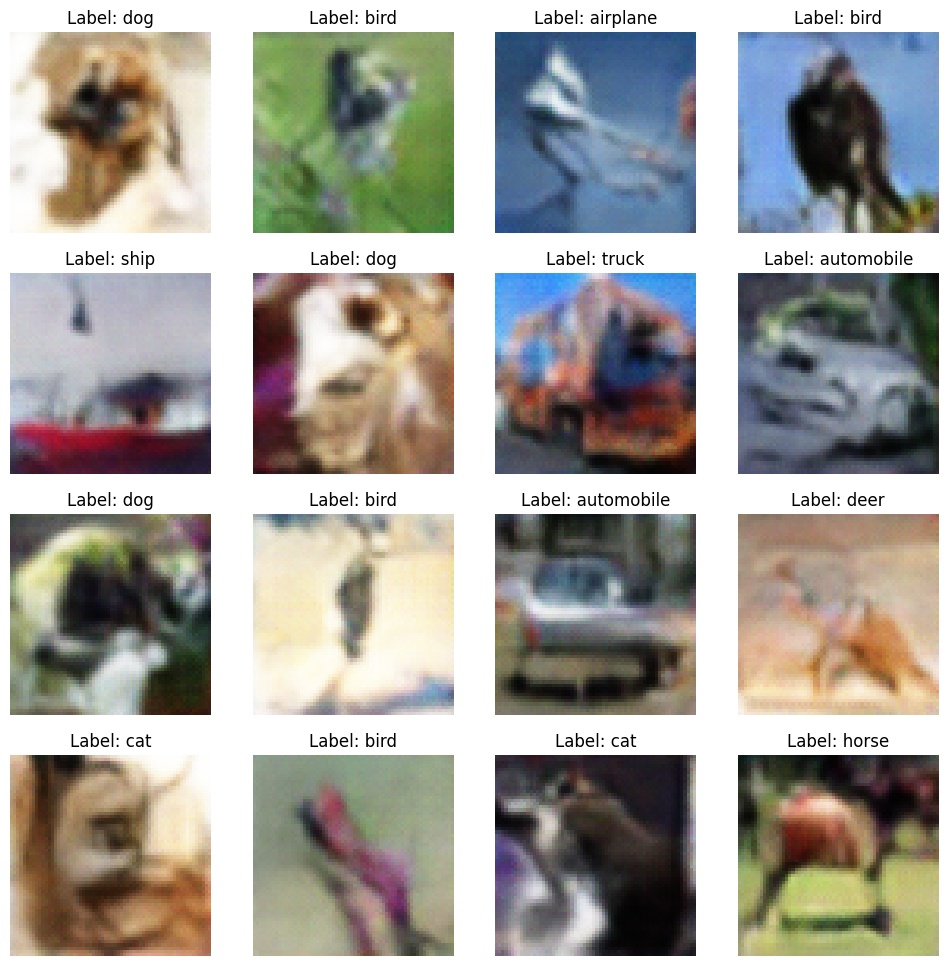

In [60]:
# Create a 4x4 grid of images
def create_grid(G):
    G.eval()
    with torch.no_grad():
        noise = torch.randn(16, config['noise_dim'], 1, 1).to(device)
        labels = torch.randint(0, 10, (16,))
        noise = torch.cat((noise, F.one_hot(labels, 10).float().view(16, 10, 1, 1).to(device)), dim=1)
        fake = G(noise)
        fig, ax = plt.subplots(4, 4, figsize=(12, 12))
        # Also tag each image with its label
        for i in range(4):
            for j in range(4):
                ax[i, j].imshow(fake[i*4+j].cpu().detach().permute(1, 2, 0)*.5+.5)
                ax[i, j].axis('off')
                ax[i, j].set_title(f'Label: {l2c[labels[i*4+j].item()]}')
        plt.show()
create_grid(G)

In [61]:
# # Save models
# torch.save(G.state_dict(), 'generator1.safetensors')
# torch.save(D.state_dict(), 'discriminator1.safetensors')

In [ ]:
def check_accuracy(D, loader):
    D.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for img, labels in train_loader:
            img = img.to(device)
            _, output = D(img)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return correct/total

In [58]:
check_accuracy(D, train_loader)

0.91766


In [59]:
check_accuracy(D, val_loader)

0.7364


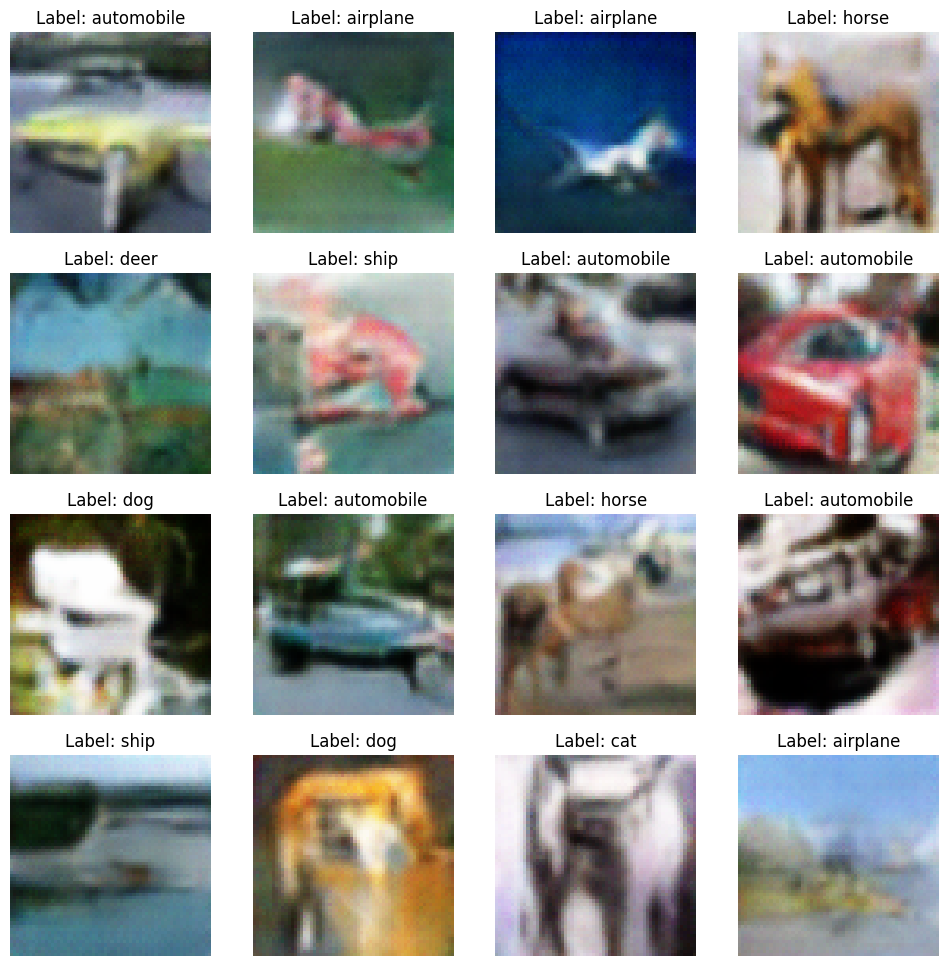

In [43]:
create_grid(G)

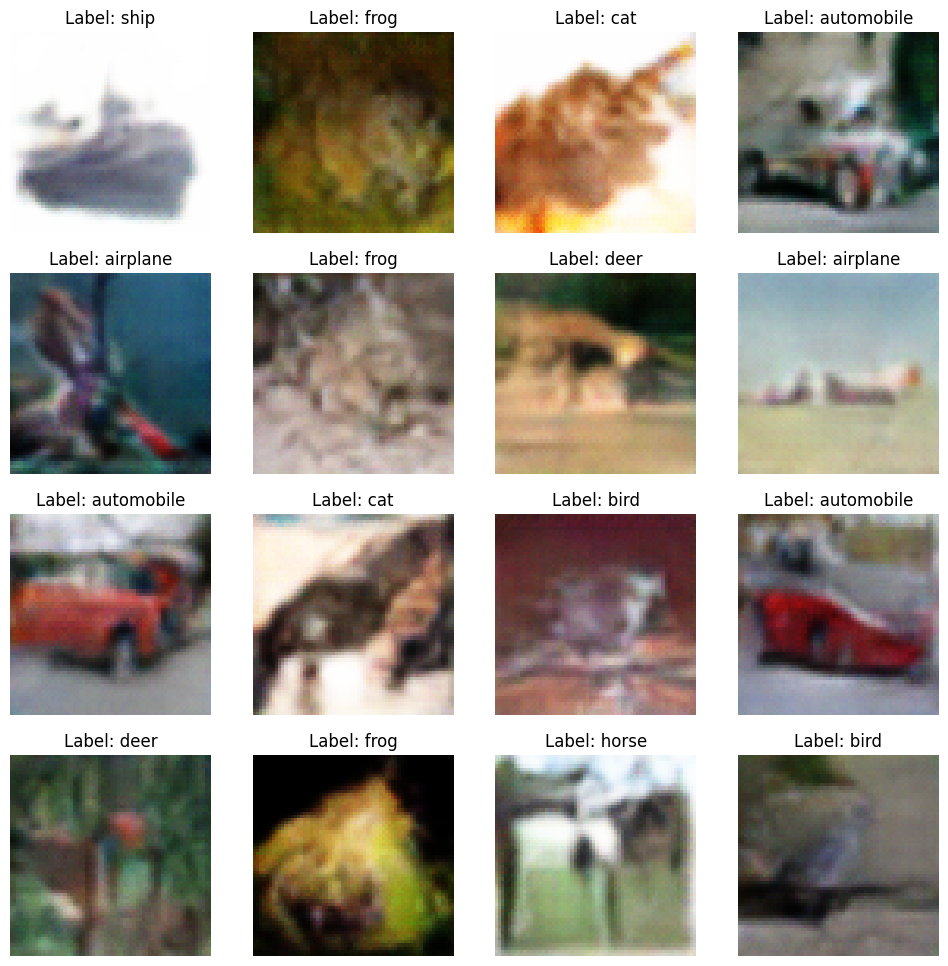

In [63]:
create_grid(G)

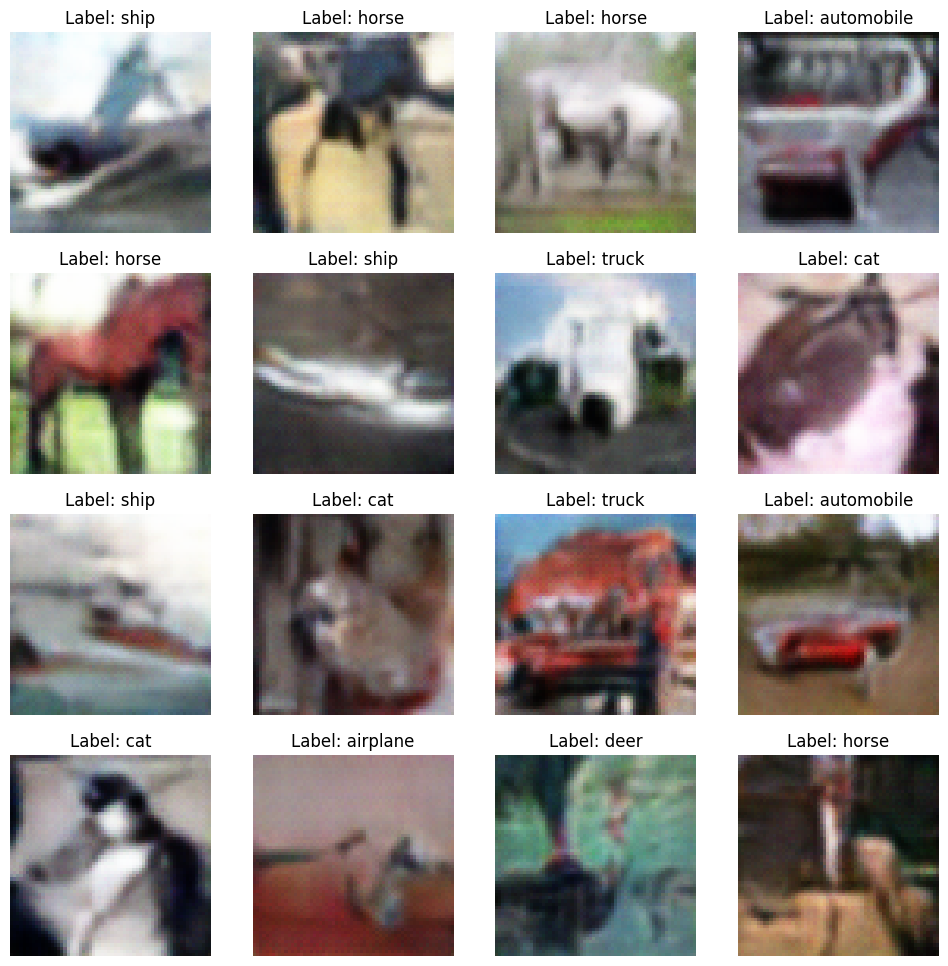

In [66]:
create_grid(G)